# Load Data

In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

# Check day time uniform and interpolate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [4]:
man = maneuvers['FY2D']

In [5]:
df = orbitals['Fengyun-2D.csv'].copy()
df = df[['Brouwer mean motion']].copy()
df.rename(columns={"Brouwer mean motion": "mean_motion"}, inplace=True)

In [6]:
df.index = pd.to_datetime(df.index)

# keep only year-month-day
df.index = df.index.normalize()

In [7]:
df.index.duplicated().any()

False

In [8]:
df.index = pd.to_datetime(df.index)
diffs = df.index.to_series().diff()
is_uniform = diffs[1:] == diffs[1]

print(f"is uniform interval in days?：{is_uniform.all()}")
print(f"interval count：{diffs.value_counts().head()}")

is uniform interval in days?：False
interval count：day_time
1 days    910
2 days    226
3 days     30
4 days     15
6 days      3
Name: count, dtype: int64


In [9]:
most_common_diff = diffs.value_counts().idxmax()

# check which dates have problems
irregular_times = diffs[diffs != most_common_diff]

print("Following dtaes records not in uniform：")
print(irregular_times) # without 16-03-04 as this date is initial strart day

Following dtaes records not in uniform：
day_time
2011-01-27      NaT
2011-02-01   2 days
2011-02-06   3 days
2011-02-25   2 days
2011-03-04   2 days
              ...  
2015-03-23   2 days
2015-03-27   2 days
2015-04-01   3 days
2015-04-06   2 days
2015-04-13   3 days
Name: day_time, Length: 277, dtype: timedelta64[ns]


In [10]:
df = df.asfreq('D')  # set day as freq
df = df.interpolate() 

In [11]:
df.index = pd.to_datetime(df.index)
diffs = df.index.to_series().diff()
is_uniform = diffs[1:] == diffs[1]

print(f"is uniform interval in days?：{is_uniform.all()}")
print(f"interval count：{diffs.value_counts().head()}")

is uniform interval in days?：True
interval count：day_time
1 days    1540
Name: count, dtype: int64


In [12]:
df.to_csv("/project_final/pipeline/data_arima/fy2d_mean_motion_data.csv", index=True) # save for arima in rstudio

# Time-series Plot

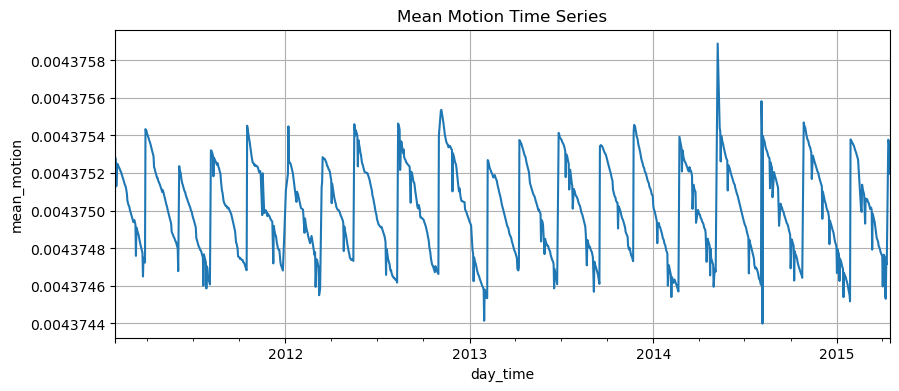

In [13]:
plt.figure(figsize=(10, 4))
df['mean_motion'].plot(title='Mean Motion Time Series')
plt.ylabel("mean_motion")
plt.grid(True)
plt.show()

# FFF test

main frequency：0.0123 cycles/day；cycles ≃ 81.1 天


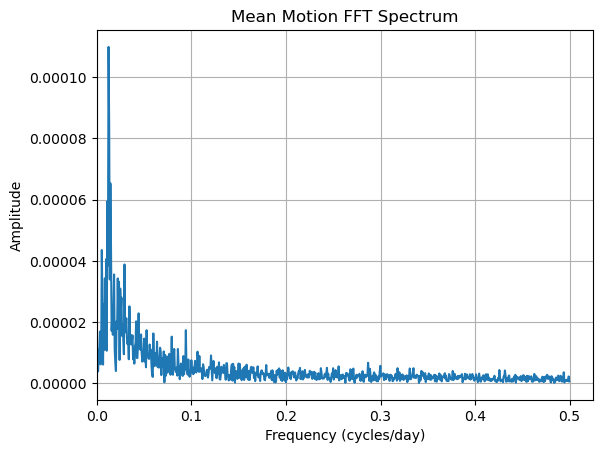

In [14]:
y = df['mean_motion'].values
y_detrend = y - y.mean()

# y_detrend = np.diff(y)

n = len(y_detrend)
freqs = np.fft.fftfreq(n, d=1.0)
fft_vals = np.abs(np.fft.fft(y_detrend))

mask = freqs > 0
freqs_pos = freqs[mask]
amps_pos  = np.abs(fft_vals)[mask]

idx_dom   = np.argmax(amps_pos)
f_dom     = freqs_pos[idx_dom]      # 
period_dom= 1.0 / f_dom             # units in days

print(f"main frequency：{f_dom:.4f} cycles/day；cycles ≃ {period_dom:.1f} 天")

plt.plot(freqs_pos, amps_pos)
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.title("Mean Motion FFT Spectrum")
plt.xlim(0, ) 
plt.grid(True)
plt.show()

# ADF, PACF, ACF

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [16]:
result = adfuller(df['mean_motion'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.780446334720047
p-value: 8.44521714106938e-12


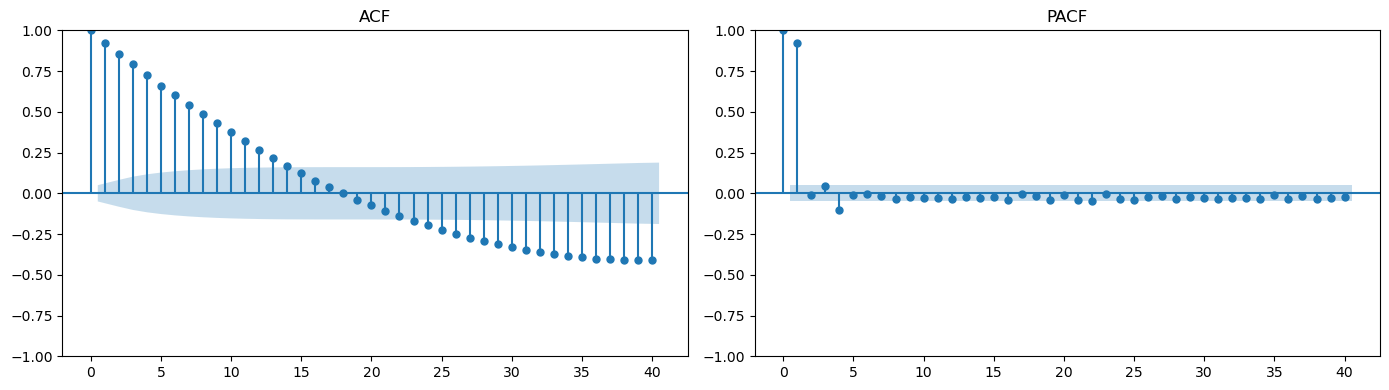

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['mean_motion'], ax=ax[0], lags=40)
plot_pacf(df['mean_motion'], ax=ax[1], lags=40, method='ywm')  # ywm are more stable
ax[0].set_title("ACF")
ax[1].set_title("PACF")
plt.tight_layout()
plt.show()

ARIMA(0,0,2)

# ARIMA Parameters select and model builds and predictions

Please check Rmd Documents

Final result is using AIC, based on result, choose ARIMA(4,0,3) rather than diff

# Forecast Method with next train steps -  With train test split

In [18]:
arima_pred = pd.read_csv("/project_final/pipeline/data_arima/fy2d_arima_predictions_with_dates.csv", parse_dates=["date"])
arima_pred.set_index("date", inplace=True)

In [19]:
arima_pred.duplicated().sum()

0

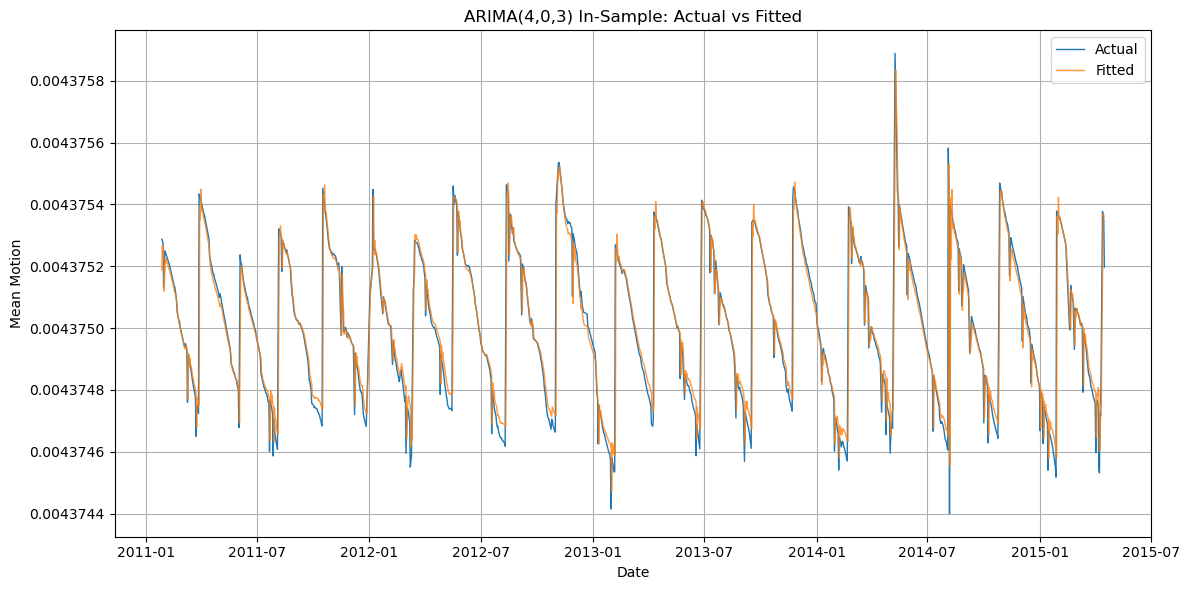

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(arima_pred.index, arima_pred["actual"], label="Actual", linewidth=1)
plt.plot(arima_pred.index, arima_pred["fitted"], label="Fitted", linewidth=1, alpha=0.8)

plt.title("ARIMA(4,0,3) In‑Sample: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get ARIMA Residual from prediction vs true value

In [21]:
# get res -  following david's forms
arima_pred['residual'] = arima_pred['actual'] - arima_pred['fitted']

print(arima_pred[['actual', 'fitted', 'residual']].head())

              actual    fitted      residual
date                                        
2011-01-27  0.004375  0.004375  1.000031e-07
2011-01-28  0.004375  0.004375  1.496561e-08
2011-01-29  0.004375  0.004375  1.159205e-08
2011-01-30  0.004375  0.004375 -1.244605e-07
2011-01-31  0.004375  0.004375  6.979012e-08


In [22]:
arima_pred.to_csv("/project_final/result/fy2d_arima_residuals.csv", index=True)

# Check residuals - distribution and QQ

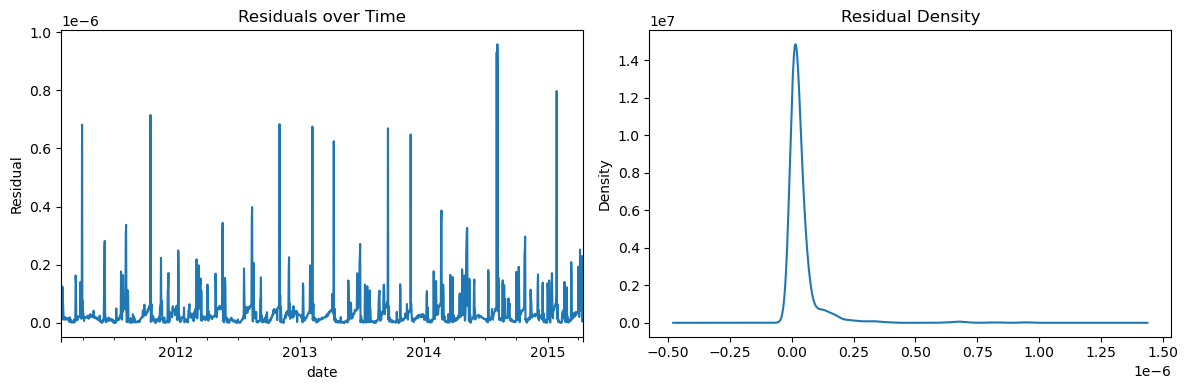

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

np.abs(arima_pred['residual']).plot(ax=ax[0], title="Residuals over Time")
ax[0].set_ylabel("Residual")

np.abs(arima_pred['residual']).plot(kind='kde', ax=ax[1], title="Residual Density")

plt.tight_layout()
plt.show()

In [24]:
import scipy.stats as stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


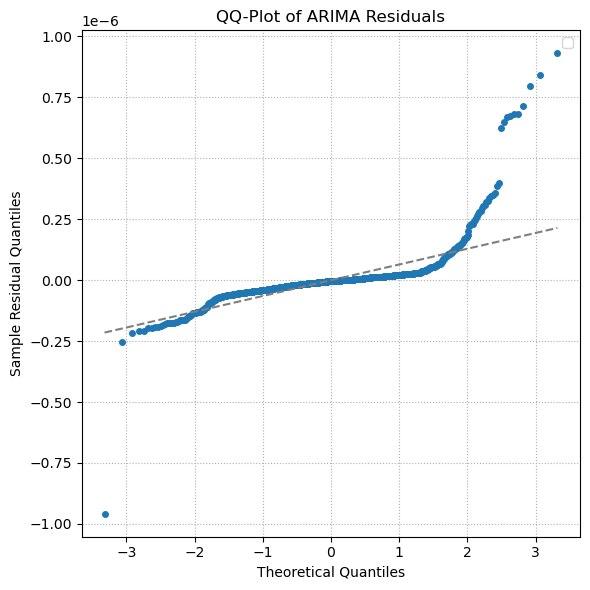

In [25]:
arima_res = arima_pred['residual']

# get qq plts for res
fig, ax = plt.subplots(figsize=(6,6))
stats.probplot(arima_res, dist="norm", plot=ax)

dots, line = ax.get_lines()
dots.set_marker('o')
dots.set_markersize(4)
dots.set_color('tab:blue')

line.set_linestyle('--')
line.set_color('tab:gray')

ax.grid(True, linestyle=':', alpha=1)
ax.set_title("QQ-Plot of ARIMA Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Residual Quantiles")
ax.legend()

plt.tight_layout()
plt.show()

# Extract anomlies

In [26]:
import scipy.stats as sts

In [27]:
# get means and var for res
mu    = arima_res.mean()
sigma = arima_res.std()

In [28]:
# p_low, p_high = sts.norm.cdf([-2.35, +2.45])
# print("percentile range", p_low, p_high)

In [29]:
# low, high = arima_res.quantile([p_low, p_high])
# print("anomlies thresholds selected：", low, high)

In [30]:
# get anomalies
# anomalies = arima_res[(arima_res < low) | (arima_res > high)]
anomalies = arima_res[np.abs(arima_res - mu) > 3 * sigma] #use sigma rules here because distribution of res seems like normal
print("number of anomalies：", len(anomalies))

number of anomalies： 26


# Visulize result

In [31]:
manoeuvre_dates = pd.to_datetime(man['median_day_time']).dt.date
manoeuvre_dates = pd.to_datetime(manoeuvre_dates)
manoeuvre_dates = manoeuvre_dates[manoeuvre_dates.isin(df.index)]

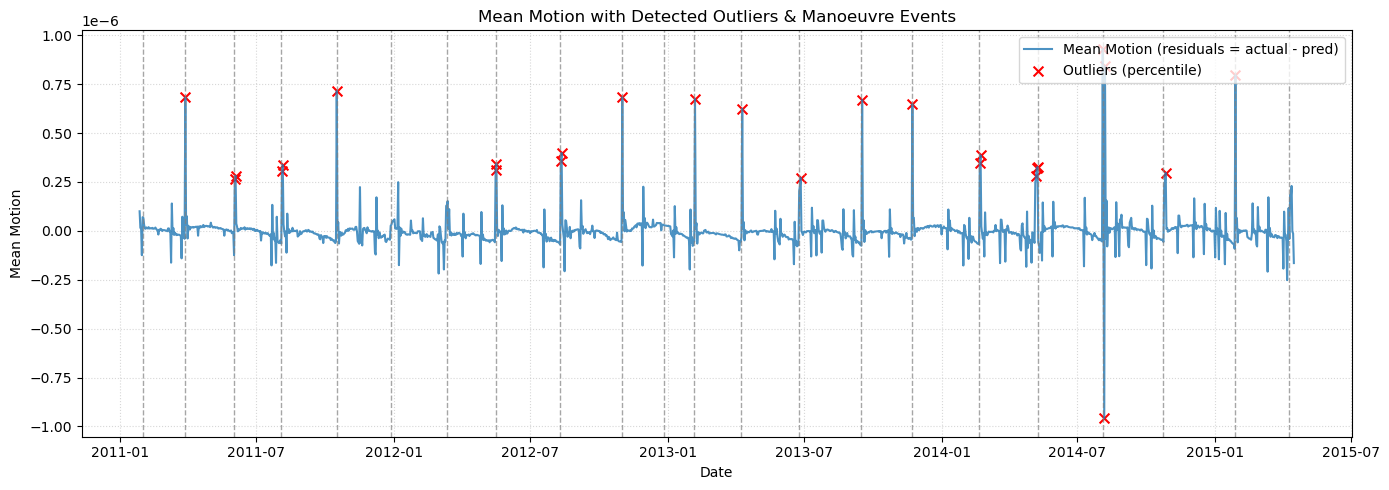

In [32]:
plt.figure(figsize=(14, 5))

# # 1) plt actual
# plt.plot(arima_pred.index, 
#          arima_pred['actual'], 
#          label='Mean Motion (actual)', 
#          color='C0', 
#          alpha=0.8)

# 1) plt -residuals
plt.plot(arima_pred.index, 
         arima_pred['residual'], 
         label='Mean Motion (residuals = actual - pred)', 
         color='C0', 
         alpha=0.8)

# 2) plt man
for dt in manoeuvre_dates:
    plt.axvline(x=dt,
                color='gray',
                linestyle='--',
                linewidth=1,
                alpha=0.7)
    
# 3) plt anomalies
plt.scatter(
    anomalies.index,
    arima_pred.loc[anomalies.index, 'residual'],
    color='red',
    marker='x',
    s=50,
    label='Outliers (percentile)'
)

plt.title("Mean Motion with Detected Outliers & Manoeuvre Events")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

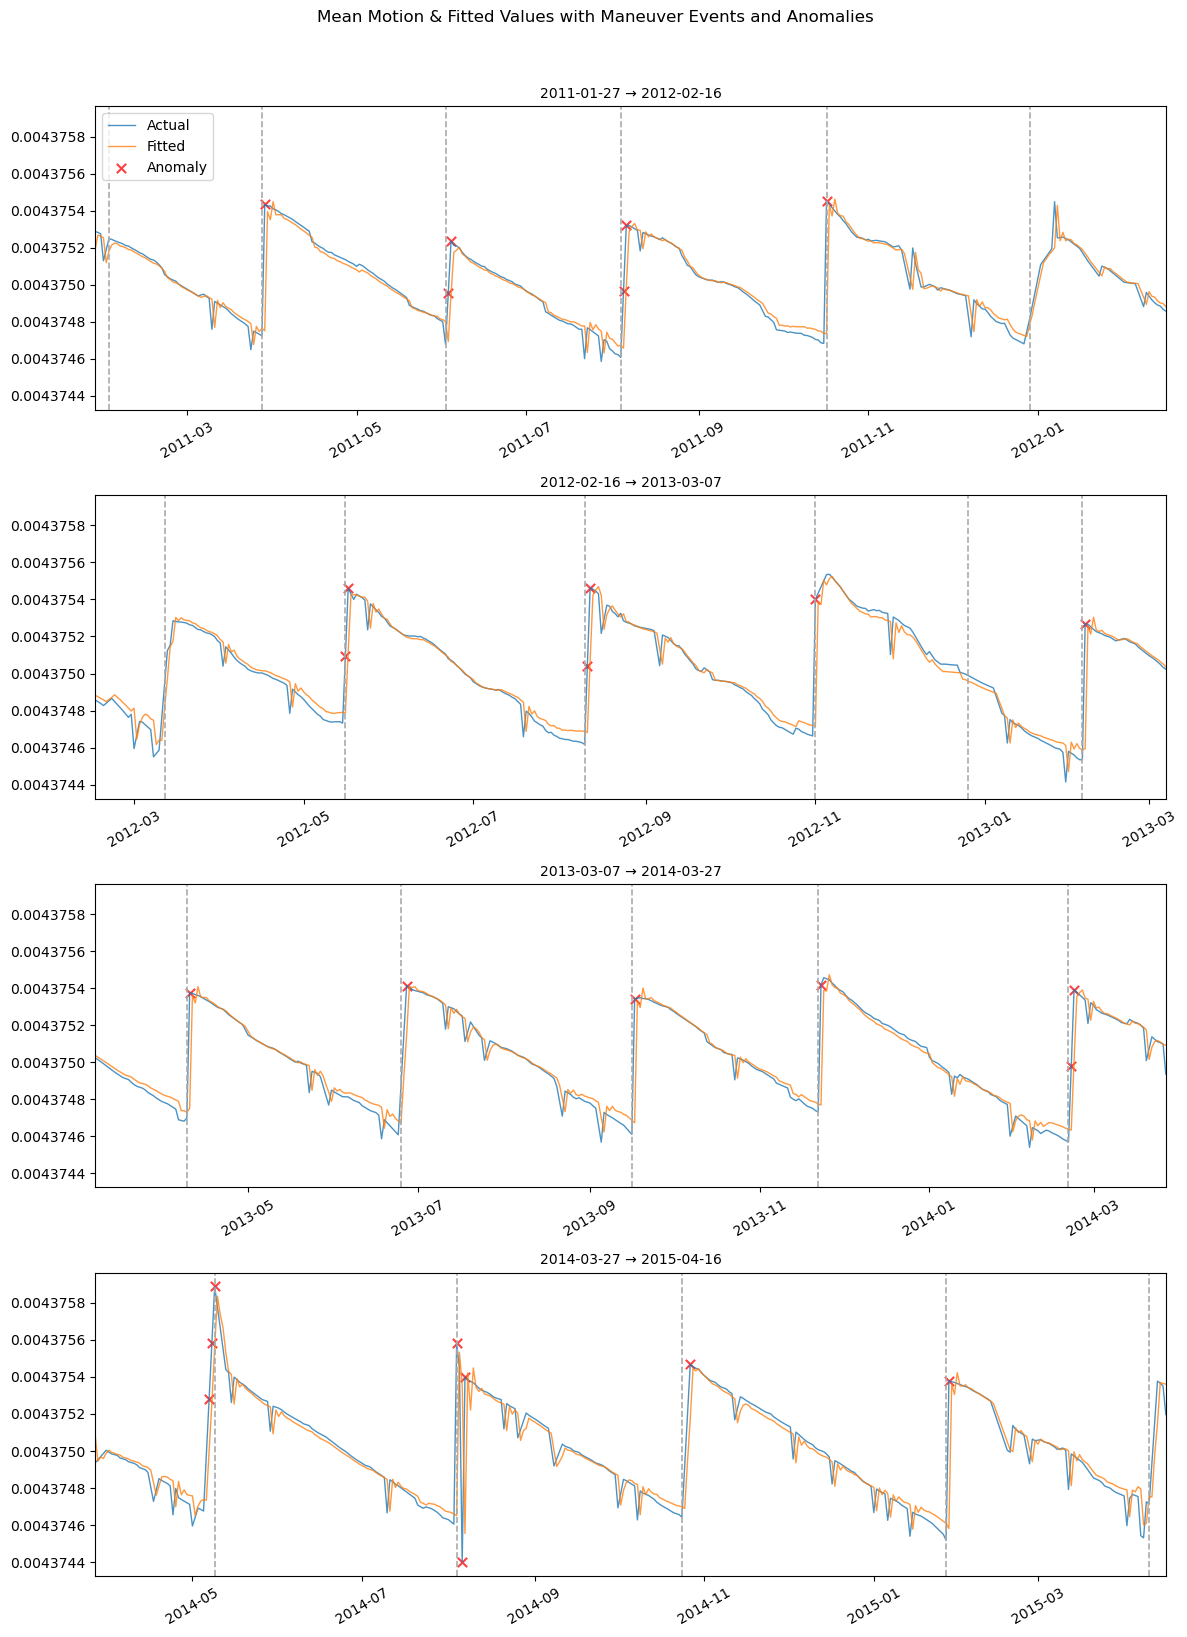

In [33]:
# get multi-cols plts
start, end = arima_pred.index.min(), arima_pred.index.max()
knots = pd.date_range(start, end, periods=5)
intervals = list(zip(knots[:-1], knots[1:]))

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = arima_pred.loc[seg_start:seg_end]
    
    # actual
    ax.plot(
        segment.index, segment['actual'],
        label='Actual', color='#1f77b4', alpha=0.8, linewidth=1.0
    )
    # plt fitted
    ax.plot(
        segment.index, segment['fitted'],
        label='Fitted', color='#ff7f0e', alpha=0.8, linewidth=1.0
    )
    
    # # plt -residuals
    # plt.plot(arima_pred.index, 
	# 		arima_pred['residual'], 
	# 		label='Mean Motion (residuals = actual - pred)', 
	# 		color='C0', 
	# 		alpha=0.8)
    
    # 3) plt anomalies
    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1,
        segment.loc[idx1, 'actual'],
        color='red', 
        marker='x',
        alpha = 0.75,
        s=45,
        label='Anomaly'
    )
    
    # 4) plt man
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='#aaaaaa',
                linestyle='--', linewidth=1.2, alpha=1.0
            )
    
    # tight layout
    ax.set_xlim(seg_start, seg_end)
    # ax.grid(True, linestyle=':', alpha=0.5)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Mean Motion & Fitted Values with Maneuver Events and Anomalies",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

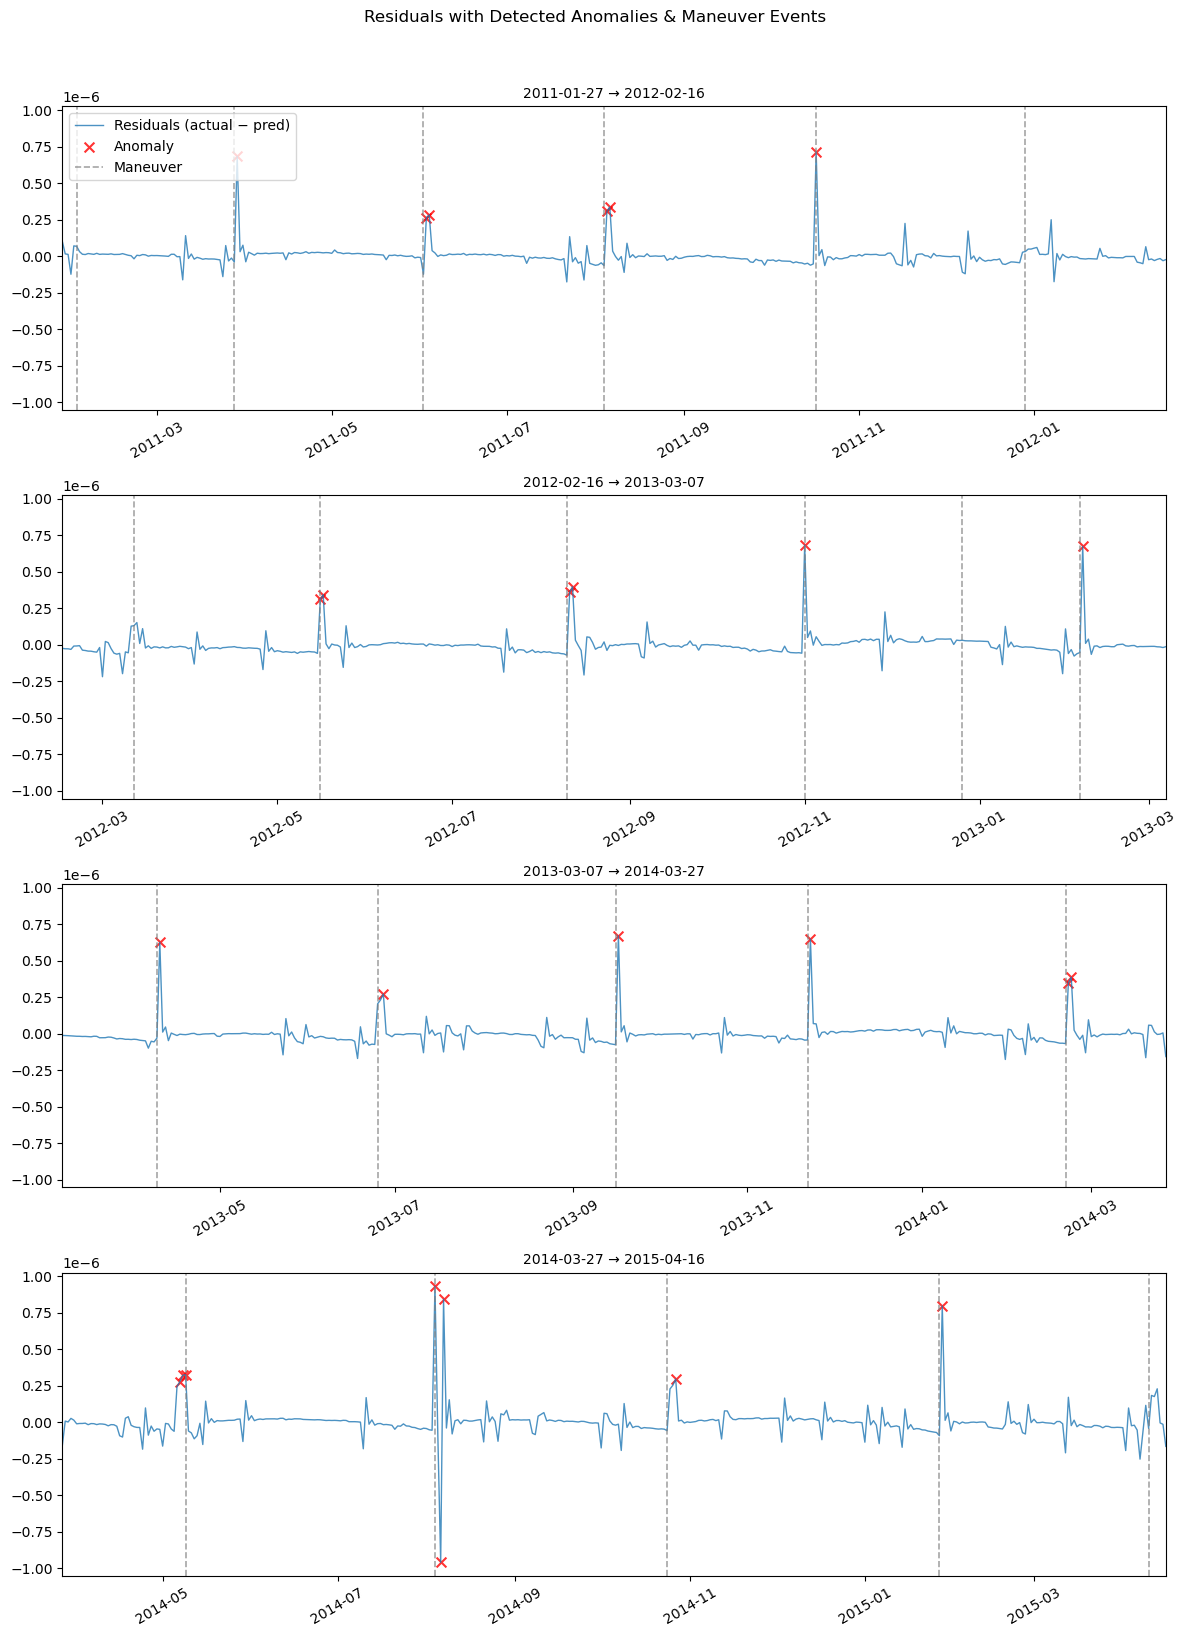

In [34]:
# residuals

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = arima_pred.loc[seg_start:seg_end]
    
    ax.plot(
        segment.index, segment['residual'],
        label='Residuals (actual − pred)',
        color='C0', alpha=0.8, linewidth=1.0
    )

    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1, segment.loc[idx1, 'residual'],
        color='red', marker='x', s=50, alpha=0.8,
        label='Anomaly'
    )
    
    first = True
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='gray', linestyle='--',
                linewidth=1.2, alpha=0.7,
                label='Maneuver' if first else None
            )
            first = False
    
    ax.set_xlim(seg_start, seg_end)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Residuals with Detected Anomalies & Maneuver Events",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

# Record num of man and anomlies

In [35]:
# records num of anomlies and man
man_df   = man.copy()             # man
anom_idx = anomalies.index        # outliers index

man_days  = pd.to_datetime(man_df['median_day_time']).dt.normalize()
anom_days = anom_idx.normalize()

anom_set = set(anom_days)

# check deteced in +- n days range
n = 3 

matched_manoeuvres = []
unmatched_manoeuvres = []

for d in man_days:
    window = set(d + pd.to_timedelta(offset, unit='D') for offset in range(-n, n+1))
    
    if window & anom_set:
        matched_manoeuvres.append(d)
    else:
        unmatched_manoeuvres.append(d)

summary = pd.DataFrame({
    "category": [
        "total_manoeuvres",
        "total_anomalies",
        f"manoeuvres_matched_within_±{n}d",
        f"manoeuvres_unmatched_within_±{n}d"
    ],
    "count": [
        len(man_days),
        len(anom_days),
        len(matched_manoeuvres),
        len(unmatched_manoeuvres)
    ]
})

summary

,category,count
0,total_manoeuvres,22
1,total_anomalies,26
2,manoeuvres_matched_within_±3d,17
3,manoeuvres_unmatched_within_±3d,5
